# Review

In the previous notebook (`1_dataprep.ipynb`), we:

1. Processed drone imagery and building footprint data (GeoJSON)
2. Generated binary mask images from building footprints
3. Created patches from both RGB drone imagery and building masks
4. Implemented a custom PyTorch Dataset (BuildingsDroneDataset)
5. Set up data augmentation and preprocessing pipelines
6. Created training and validation DataLoaders

**You’ll learn to**:
- Replicate your own version of U-Net from the research paper
- Ccreate a complete deep learning training loop
- Make an inferencing pipeline to use the trained model.

# Task 1: Initial Setup

In [ ]:
# Mount Google Drive to access files from your Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libaries

In [3]:
%%capture
!pip install rasterio

In [4]:
import sys
import os
from pathlib import Path

notebook_path=os.getcwd()

## Preparing Directories

In [ ]:
# Set up main project and data directories using pathlib
NB_DIR = Path(notebook_path)
PROJECT_DIR = NB_DIR
print(f'Project directory: {PROJECT_DIR}')

# Define data subdirectories
DATA_DIR = PROJECT_DIR / 'data'
RAW_DATA_DIR = DATA_DIR / '0_raw'
INTERIM_DATA_DIR = DATA_DIR / '1_interim'
PATCH_DIR = DATA_DIR / '2_patches'

# List of folders to create if they don't exist
folder_list = [
    DATA_DIR,
    RAW_DATA_DIR,
    INTERIM_DATA_DIR,
    PATCH_DIR,
]

# Create directories if they do not exist
for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Set random seed for reproducibility
RANDOM_SEED = 42

Project directory: /content


## Bringing DataLoader From Previous Notebook

In [ ]:
# Run the script below,
# it is a workaround for a bug that happens during patch creation in Google Colab/Google Drive

import shutil
from glob import glob

# Define source and destination directories
dst_dir = str(DATA_DIR)
src_dir = '/content/drive/MyDrive/Drone-Image-DL-Classification'
src_dir

# Copy the data directory from Google Drive to the local workspace
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
print(f"Copied {src_dir} to {dst_dir}")
print(f'Patch directory: {PATCH_DIR}')

# Get lists of label and patch files
label_list = glob(str(PATCH_DIR/"label/*.tif"))
patch_list = glob(str(PATCH_DIR/"patch/*.tif"))

# Extract indices from filenames
label_idx = sorted([int(l.split('/')[-1].split('_')[0]) for l in label_list])
patch_idx = sorted([int(l.split('/')[-1].split('_')[0]) for l in patch_list])

my_label_set = set(label_idx)
my_patch_set = set(patch_idx)
print(f'Number of label files: {len(label_idx)}')

# Create sets of expected indices based on the range
complete_label_set = set(range(label_idx[0], label_idx[-1]-1))
complete_patch_set = set(range(patch_idx[0], patch_idx[-1]-1))

# Find missing indices in labels and patches
missing_label_idx = set(sorted(complete_label_set - my_label_set))
missing_patch_idx = set(sorted(complete_patch_set - my_patch_set))

# Union of missing indices
missing_set = missing_label_idx.union(missing_patch_idx)

# Remove files with missing indices from both patch and label directories
for i in missing_set:
  my_path = PATCH_DIR/'patch'/f'{i}_img.tif'
  if my_path.exists():
    os.remove(str(my_path))

  my_path = PATCH_DIR/'label'/f'{i}_lbl.tif'
  if my_path.exists():
    os.remove(str(my_path))

Copied /content/drive/MyDrive/Drone-Image-DL-Classification to /content/data
Patch directory: /content/data/2_patches
Number of label files: 989


In [ ]:
import os
from random import randint

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


class BuildingsDroneDataset(Dataset):
    """Dataset for building segmentation from drone imagery.

    Args:
        patch_dir (str): path to patch images folder (TIF format)
        label_dir (str): path to label masks folder (TIF format)
        augmentation (albumentations.Compose): data transformation pipeline
        preprocessing (albumentations.Compose): data preprocessing
    """

    def __init__(
        self,
        patch_dir,
        label_dir,
        augmentation=None,
        preprocessing=None,
    ):
        # Get paths to all TIF files in the directories
        self.patch_paths = [
            os.path.join(patch_dir, file_name)
            for file_name in sorted(os.listdir(patch_dir))
            if file_name.endswith(".tif")
        ]

        self.label_paths = [
            os.path.join(label_dir, file_name)
            for file_name in sorted(os.listdir(label_dir))
            if file_name.endswith(".tif")
        ]

        # Verify that we have matching number of patches and labels
        assert len(self.patch_paths) == len(
            self.label_paths
        ), f"Number of patches ({len(self.patch_paths)}) and labels ({len(self.label_paths)}) don't match"

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Read TIF images using rasterio
        with rio.open(self.patch_paths[i]) as patch_file:
            # Read all bands and transpose to (channels, height, width)
            patch = patch_file.read()
            # Convert to (height, width, channels) for albumentations
            patch = np.transpose(patch, (1, 2, 0))

        with rio.open(self.label_paths[i]) as label_file:
            # Assume mask is single channel
            mask = label_file.read(1)

        # Ensure mask has values 0 and 1 only
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=patch, mask=mask)
            patch, mask = sample["image"], sample["mask"]

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=patch, mask=mask)
            patch, mask = sample["image"], sample["mask"]

        # Convert numpy arrays to PyTorch tensors
        patch = torch.from_numpy(patch)
        mask = torch.from_numpy(mask)

        return patch, mask

    def __len__(self):
        return len(self.patch_paths)

    def plot_pair(self, idx=None):
        if idx is not None:
            idx = idx
        else:
            idx = randint(0, len(self) - 1)
        _, ax = plt.subplots(1, 2, figsize=(8, 4))

        img, mask = self[idx]

        # Convert tensors back to numpy for plotting
        img = img.numpy()
        mask = mask.numpy()

        # Handle different dimensions based on preprocessing
        if len(img.shape) == 3 and img.shape[0] == 3:  # CHW format
            img = np.transpose(img, (1, 2, 0))  # Convert to HWC for plotting

        ax[0].imshow(img)
        ax[0].set_title("Drone Image")

        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Building Mask")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        plt.suptitle(f"Sample {idx}")
        plt.tight_layout()


def get_training_augmentation():
    """
    Simple augmentation pipeline for drone imagery training data
    """
    train_transform = [
        # Basic spatial augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
    return A.Compose(train_transform)


def get_preprocessing():
    """
    Simple preprocessing function for drone imagery

    Returns:
        Preprocessing transform for normalization and channel reordering
    """

    # Define regular functions instead of lambdas
    def to_float_and_normalize(image, **kwargs):
        return image.astype(np.float32) / 255.0

    def transpose_to_chw(image, **kwargs):
        return image.transpose(2, 0, 1)

    def to_float32(mask, **kwargs):
        return mask.astype(np.float32)

    _transform = [
        # Scale to [0,1] range
        A.Lambda(image=to_float_and_normalize),
        # Convert to PyTorch format (CHW)
        A.Lambda(image=transpose_to_chw),
        # Ensure mask is float32
        A.Lambda(mask=to_float32),
    ]
    return A.Compose(_transform)


def create_dataloaders(
    patch_dir, label_dir, batch_size=8, val_split=0.2, random_state=42, num_workers=4
):
    """
    Create train and validation dataloaders

    Args:
        patch_dir: Directory containing image patches
        label_dir: Directory containing label masks
        batch_size: Batch size for dataloaders
        val_split: Validation split ratio (0.0-1.0)
        random_state: Random seed for reproducibility
        num_workers: Number of workers for DataLoader

    Returns:
        train_loader, val_loader: DataLoader objects for training and validation
    """
    # Create dataset with augmentation and preprocessing
    dataset = BuildingsDroneDataset(
        patch_dir=patch_dir,
        label_dir=label_dir,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(),
    )

    # Split dataset into training and validation
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(
        indices, test_size=val_split, random_state=random_state
    )

    # Create subset datasets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, val_loader


In [24]:
# Create dataset with augmentation and preprocessing
dataset = BuildingsDroneDataset(
    patch_dir=PATCH_DIR/'patch',
    label_dir=PATCH_DIR/'label',
)

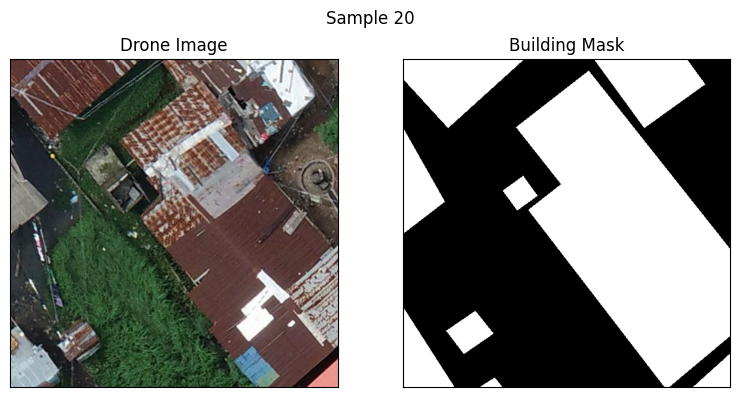

In [25]:
# Visualize a sample image and mask
sample_idx = 20 # Change this to see different samples
dataset.plot_pair(sample_idx)

<div class="alert alert-block alert-success">
<h3>Excercise 1</h3>
Creating Data Loader
<p style="color: red">NOTE: YOU HAVE TO COMPLETE THIS EXERCISE TO BE ABLE TO PROPERLY RUN THE REST OF THE NOTEBOOK</o>
</div>

Without looking at the previous module, can you create train and validation dataloader?

Hint: use `4` as `batch_size`, and `2` as `num_workers`.

Higher number might mess up the google colab kernel (you will have to restart your notebook session if this happen).

<details>
<summary>Click to see answer.</summary>

Run this script in the cell below<br>
```python
# Create dataloaders
train_loader, val_loader = create_dataloaders(
    patch_dir=PATCH_DIR/'patch',
    label_dir=PATCH_DIR/'label',
    batch_size=4,
    num_workers=2
)
```
</details>

In [26]:
# Create dataloaders
train_loader, val_loader = create_dataloaders(
    patch_dir=PATCH_DIR/'patch',
    label_dir=PATCH_DIR/'label',
    batch_size=4,
    num_workers=2
)

# Task 2: Model Architecture

## Introduction to U-Net architecture

U-Net is a convolutional neural network architecture designed specifically for biomedical image segmentation. It was introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015 in their paper ["U-Net: Convolutional Networks for Biomedical Image Segmentation."](https://arxiv.org/abs/1505.04597) While originally developed for medical imaging, U-Net has proven highly effective for a wide range of segmentation tasks, including our task of building segmentation from drone imagery. The main aim of the authors was to create a semantic segmentation model that could overcome the large dataset requirement for training. According to them, it was possible by:

- Making better architecture choices while building the deep learning model.
- And using good augmentation techniques on the dataset while training the model.

This led to the creation of the UNet model for semantic segmentation.

<figure style="text-align: center">
  <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=600>
  <figcaption><i>U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.<br>
  Taken from: <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/">lmb.informatik.uni-freiburg.de</a></i></figcaption>
</figure>

The image above is actually full of information to help us implement it as code.

**Basic Structure**
The architecture has a U-shape (hence the name "U-Net") with:
- A left side that compresses the image (encoder/contracting path)
- A right side that expands features back to full size (decoder/expansive path)
- Connections across the "U" (skip connections)

The Numbers and Colors Mean:
- Blue boxes: Feature maps (processed versions of the image)
- Numbers above boxes: Number of channels (like 64, 128, 256, 512, 1024)
- Numbers beside boxes: Spatial dimensions (height × width)
- Colored arrows: Different operations

We will dive deeper into the architecture while implementing it later below!


**Key Features of U-Net**
1. U-shaped Architecture: The network has a symmetric structure resembling the letter "U," consisting of:
    - A contracting path (encoder) that captures context
    - An expansive path (decoder) that enables precise localization
1. Encoder-Decoder Design:
    - Encoder: A series of convolutional layers followed by max pooling that progressively reduce spatial dimensions while increasing the feature channels
    - Decoder: A series of upsampling operations followed by convolutional layers that restore spatial dimensions while reducing feature channels
1. Skip Connections: Perhaps the most distinctive feature of U-Net is its skip connections, which connect corresponding layers in the encoder and decoder paths. These connections:
    - Allow the network to combine high-resolution features from the contracting path with upsampled features in the expansive path
    - Help preserve fine spatial details that would otherwise be lost during downsampling
    - Mitigate the vanishing gradient problem by providing alternative pathways for gradient flow
1. No Fully Connected Layers: Unlike many CNN architectures, U-Net uses only convolutional, pooling, and upsampling operations, which:
    - Makes it fully convolutional
    - Allows it to process images of arbitrary size
    - Reduces the number of parameters compared to fully connected approaches

## U-Net Implementation with PyTorch

Now we know a bit about U-Net, let's dive in by implementing it!

In [27]:
# U-Net Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F

### Double Convolutional Layer

You may notice by now that there are a lot of **3 layers of blue boxes** in the architecture. These trio of blue boxes are called **double convolutional layer** (double conv). A double conv is **two** sequences of:
- 2D convolutional layer
- 2D batch normalization layer
- and a ReLU layer

Since this is a repeating item in the architecture, let's implement it first.

In [ ]:
class DoubleConv(nn.Module):
    """
    Double Convolution block: (Conv2d -> BatchNorm -> ReLU) x 2
    This is used repeatedly throughout the U-Net architecture.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            # First convolutional layer: extracts features, preserves spatial size
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # Batch normalization for training stability
            nn.BatchNorm2d(out_channels),
            # Non-linearity
            nn.ReLU(inplace=True),

            # Second convolutional layer: further feature extraction
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            # Batch normalization again
            nn.BatchNorm2d(out_channels),
            # Non-linearity
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Pass input through the double conv block
        return self.double_conv(x)

### Contracting Path
<figure style="text-align: center">
  <img src="https://debuggercafe.com/wp-content/uploads/2023/02/unet-from-scratch-using-pytorch-unet-contracting-path.png" width=300>
  <figcaption><i>The contracting path of the UNet semantic segmentation architecture.<br>
  Taken from: <a href="https://debuggercafe.com/unet-from-scratch-using-pytorch/">debuggercafe.com</a></i></figcaption>
</figure>

Contracting path (Going Down):
- Start: You input your image (e.g., a drone image patch)
- First blue boxes (64): The image goes through two convolutional layers (blue arrows), creating 64 feature maps.
- Red arrow: Max pooling reduces the spatial size by half
- Second level (128): Two more convolutions, now creating 128 feature maps
- Continue down: This pattern repeats, doubling features (256→512→1024) while reducing size

### Down Sampling Block

Now that we have the DoubleConv block, we can implement the left side (contracting path) of the U-Net. We'll create a DownSamplingBlock that handles the transition between each level of the contracting path.

Looking at the architecture diagram, notice the red arrows pointing downward. Each of these represents a down sampling operation. The down sampling process consists of two steps:
1. **Max Pooling**: Reduces the spatial dimensions by half (height and width)
1. **Feature Extraction**: Applies another DoubleConv to extract more complex features while doubling the number of channels

This pattern creates a hierarchical representation where shallow layers capture local details (edges, textures) and deeper layers capture more semantic information with greater context but at lower resolution.

In [ ]:
class DownSamplingBlock(nn.Module):
    """
    Downsampling block for the encoder path: MaxPool -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super(DownSamplingBlock, self).__init__()
        # MaxPool2d reduces spatial dimensions by half
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # DoubleConv extracts features and increases channel depth
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        # Apply max pooling to downsample
        x = self.maxpool(x)
        # Apply double convolution for feature extraction
        x = self.double_conv(x)
        return x

<div class="alert alert-block alert-success">
<h3>Excercise 2</h3>
Max Pool Layer
</div>

What does a Max Pool Layer do?

<details>
<summary>Click to see answer.</summary>

Max Pooling is a pooling operation that calculates the maximum value for patches of a feature map, and uses it to create a downsampled (pooled) feature map.

<figure style="text-align: center">
  <img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png?20180226194350" width=300>
  <figcaption><i>Pictorial example of max-pooling<br>
  Taken from: <a href="https://computersciencewiki.org/index.php/File:MaxpoolSample2.png">computersciencewiki.org</a></i></figcaption>
</figure>
</details>

### Expansive Path

<figure style="text-align: center">
  <img src="https://debuggercafe.com/wp-content/uploads/2023/02/unet-from-scratch-using-pytorch-unet-expanding-path.png" width=300>
  <figcaption><i>The expansive path of the UNet semantic segmentation architecture.<br>
  Taken from: <a href="https://debuggercafe.com/unet-from-scratch-using-pytorch/">debuggercafe.com</a></i></figcaption>
</figure>

Expansive Path (Going Up):
- Green arrows: Upsampling increases spatial dimensions
- Gray arrows: Skip connections copy features from the left side and combine them with the right
- Each level up: Combines upsampled features with corresponding features from the left side
- Final layers: The network gradually reduces channels (512→256→128→64→2) while increasing spatial resolution

### Up Sampling Block

Now we'll implement the right side of the U-Net architecture, known as the expansive path or decoder path. This part is more complex than the contracting path because it involves two key concepts:
1. **Upsampling**: The green arrows in the architecture represent upsampling operations. Unlike downsampling which reduces spatial dimensions, upsampling increases them. We implement this using a transposed convolution (`ConvTranspose2d`), which learns how to intelligently increase the spatial dimensions while reducing the number of channels.
1. **Skip Connections**: The gray horizontal arrows in the U-Net diagram are skip connections. These are critical to the architecture's success because:
    - They connect the contracting path to the expansive path
    - They allow high-resolution features from earlier layers to be combined with upsampled features
    - They help preserve fine spatial details that would otherwise be lost during downsampling

In [ ]:
class UpSamplingBlock(nn.Module):
    """
    Upsampling block for the decoder path:
    Upsample -> Concatenate with skip connection -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()
        # Transposed convolution for upsampling (doubles spatial size, halves channels)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # After concatenation, input channels will be doubled (skip + upsampled)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip_connection):
        # Upsample input feature map
        x = self.up(x)

        # Calculate difference in spatial dimensions (height and width)
        diff_y = skip_connection.size()[2] - x.size()[2]
        diff_x = skip_connection.size()[3] - x.size()[3]

        # Pad upsampled feature map if needed to match skip connection size
        if diff_y > 0 or diff_x > 0:
            x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                          diff_y // 2, diff_y - diff_y // 2])

        # Concatenate skip connection and upsampled feature map along channel dimension
        x = torch.cat([skip_connection, x], dim=1)
        # Apply double convolution for feature extraction
        x = self.double_conv(x)
        return x

### Assembling the Complete U-Net Architecture
Now that we have defined all the building blocks of our U-Net, we can assemble them into the complete architecture. The U-Net consists of:

1. An initial double convolution that processes the input image
1. The contracting path with multiple downsampling blocks that progressively reduce spatial dimensions
1. The expansive path with multiple upsampling blocks that restore spatial dimensions
1. Skip connections that connect corresponding levels of the contracting and expansive paths
1. A final 1×1 convolution that maps the feature maps to the desired number of output classes

The architecture follows a symmetrical design where each level in the contracting path has a corresponding level in the expansive path. The number of channels follows a pattern of doubling during downsampling (64→128→256→512→1024) and halving during upsampling (1024→512→256→128→64).

In [ ]:
class UNet(nn.Module):
    """
    Complete U-Net architecture using modular building blocks.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Initial double convolution (feature extraction from input)
        self.initial_conv = DoubleConv(in_channels, 64)

        # Encoder (Downsampling) path: progressively reduces spatial size, increases channels
        self.down1 = DownSamplingBlock(64, 128)
        self.down2 = DownSamplingBlock(128, 256)
        self.down3 = DownSamplingBlock(256, 512)
        self.down4 = DownSamplingBlock(512, 1024)

        # Decoder (Upsampling) path: increases spatial size, decreases channels, uses skip connections
        self.up1 = UpSamplingBlock(1024, 512)
        self.up2 = UpSamplingBlock(512, 256)
        self.up3 = UpSamplingBlock(256, 128)
        self.up4 = UpSamplingBlock(128, 64)

        # Final output layer: 1x1 convolution to map to desired output channels (e.g., mask)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder: save outputs for skip connections
        x1 = self.initial_conv(x)   # First double conv
        x2 = self.down1(x1)         # Downsample 1
        x3 = self.down2(x2)         # Downsample 2
        x4 = self.down3(x3)         # Downsample 3
        x5 = self.down4(x4)         # Bottom of "U"

        # Decoder: upsample and concatenate with corresponding encoder outputs
        x = self.up1(x5, x4)        # Upsample 1 + skip connection
        x = self.up2(x, x3)         # Upsample 2 + skip connection
        x = self.up3(x, x2)         # Upsample 3 + skip connection
        x = self.up4(x, x1)         # Upsample 4 + skip connection

        # Final output: segmentation mask
        output = self.out_conv(x)

        return output

## Testing Our U-Net Implementation
Before we start training the model, it's essential to perform some quick tests to verify that our implementation is working correctly. We'll do this in two ways:

1. **Model Summary**: We'll print a summary of our model architecture to verify the number of parameters and structure
1. **Forward Pass** Test: We'll run a random input tensor through the model to ensure all dimensions work correctly

These sanity checks help us catch any implementation errors early, saving debugging time later. They verify that:
- The model builds successfully
- Tensors flow through the network with expected shapes
- Skip connections are properly aligned
- The output has the correct dimensions for our segmentation task

In [32]:
from torchsummary import summary

In [33]:
model = UNet(in_channels=3, out_channels=1)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(3, 512, 512))  # Adjust input size to match your patches

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

<div class="alert alert-block alert-success">
<h3>Excercise 3</h3>
Number of parameters
</div>

1. What is the `Estimated Total Size (MB)` represent? How is this number helpful?
1. What do you think you can do to increase or decrease it?

<details>
<summary>Click to see answer.</summary>

1. The "Estimated Total Size" in the model summary refers to the approximate memory footprint required by the model during training. The total represents the estimated peak memory usage during training. This is important to consider because:
    - It tells you if your model will fit in your GPU's memory
    - It helps you determine appropriate batch sizes
    - It indicates if you might need memory optimization techniques (like gradient checkpointing or mixed precision training)
1. Some strategies to increase or reduce it is by
    - Changing input dimension (e.g. 512 to 256 will decrease the estimated memory footprint)
    - Remove some layers from the architecture (e.g. `BatchNorm2d`)
    - Change the maximum feature channels (e.g., cap at 512 instead of 1024)
    - Changing the batch size when initiating dataloader. This might not change the "Total" per se, but it can definitely reduce the memory needed in each iteration of the training since batch size implies the number of image stored to memory in each loop, the bigger the number, the more image stored, the more memory needed.

</details>

In [35]:
# Forward pass test with random input
def test_forward_pass():
    # Create random input tensor (batch_size, channels, height, width)
    x = torch.randn(2, 3, 512, 512)

    # Move to the same device as model
    x = x.to(next(model.parameters()).device)

    print(f"Input shape: {x.shape}")

    # Forward pass
    with torch.no_grad():
        output = model(x)

    print(f"Output shape: {output.shape}")
    print(f"Min output value: {output.min().item():.4f}, Max output value: {output.max().item():.4f}")

    # Expected output shape should be [batch_size, out_channels, height, width]
    expected_shape = (x.shape[0], 1, x.shape[2], x.shape[3])
    assert output.shape == expected_shape, f"Expected shape {expected_shape}, got {output.shape}"

    print("✅ Forward pass test passed!")

# Run the test
test_forward_pass()

Input shape: torch.Size([2, 3, 512, 512])
Output shape: torch.Size([2, 1, 512, 512])
Min output value: -2.3538, Max output value: 1.0444
✅ Forward pass test passed!


# Task 3: Model Training Setup
After implementing the U-Net architecture, we need to set up the training components. For image segmentation, we need to carefully choose the right loss function, optimizer, and hyperparameters to effectively train our model.

## Loss Functions for Segmentation

For **binary** segmentation tasks like building detection, we have several options for loss functions:
- Binary Cross-Entropy (BCE): The standard loss function for binary classification, applied pixel-wise
- Dice Loss: Measures the overlap between the predicted and ground truth masks
- Combined BCE-Dice Loss: Combines the benefits of both

For simplicity, we'll use Binary Cross-Entropy with Logits (BCEWithLogitsLoss), which combines a sigmoid activation and binary cross-entropy in one function for better numerical stability.

## Optimizer Selection
We'll use the Adam optimizer, which is a popular choice for deep learning tasks due to its adaptive learning rates and momentum.

## Hyperparameters
For our training setup, we'll define basic hyperparameters:
- Learning rate
- Number of epochs
- Batch size (already set in our DataLoader)
- Device selection (CPU or GPU)

In [36]:
# Set up training components
import torch.optim as optim

In [37]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 5  # Start with a small number for testing

# Initialize the model
model = UNet(in_channels=3, out_channels=1)

# Choose device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function
# BCEWithLogitsLoss combines sigmoid activation and binary cross entropy
criterion = nn.BCEWithLogitsLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
print(f"Model initialized on {device}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}, Learning Rate: {learning_rate}")
print(f"Training will run for {num_epochs} epochs")

Model initialized on cuda
Loss function: BCEWithLogitsLoss
Optimizer: Adam, Learning Rate: 0.001
Training will run for 5 epochs


# Task 4: Training Loop Implementation
Now comes the exciting part - training our U-Net model to recognize buildings in drone imagery! We've set up our model, loss function, and optimizer, the training loop is where all our preparations come together. Here we'll implement:

- Training Function: Responsible for passing batches through our model, calculating loss, and updating weights
- Validation Function: Evaluates model performance on unseen data without updating weights
- Metrics Tracking: Measures how well our model is performing with segmentation-specific metrics

Let's break down what happens in each training epoch:

- The model processes batches of images and produces predicted masks
- We compare these predictions to ground truth masks using our loss function
- Backpropagation calculates gradients and updates model weights
- Periodically, we evaluate on validation data to check for overfitting
- We track metrics to measure real-world performance beyond just loss values

## Performance Metrics for Segmentation

For building segmentation, we'll track two important metrics:

- Intersection over Union (IoU): Measures the overlap between predicted and ground truth masks
- Dice Coefficient: Similar to IoU, measures the overlap but with a different formula

The Intersection over Union (IoU) and Dice coefficient are particularly valuable for segmentation tasks as they directly measure overlap between predicted and actual masks. These metrics provide a better assessment of segmentation quality than accuracy alone.

### Implementing Metrics

In [ ]:
# Define metrics functions

def dice_coefficient(y_pred, y_true, smooth=1e-6):
    """
    Calculate Dice coefficient

    Args:
        y_pred: Predicted masks, after sigmoid (B, 1, H, W)
        y_true: Ground truth masks (B, 1, H, W)
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice coefficient (0-1, higher is better)
    """
    # Dice coefficient measures the overlap between predicted and ground truth masks.
    # Formula: Dice = 2 * |A ∩ B| / (|A| + |B|)
    # Where A is the predicted mask, B is the ground truth mask.
    # Dice ranges from 0 (no overlap) to 1 (perfect overlap).

    # Flatten the tensors to 1D for calculation
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)

    # Calculate intersection (common pixels between prediction and ground truth)
    intersection = (y_pred * y_true).sum()

    # Dice formula with smoothing to avoid division by zero
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

    return dice.item()

def iou_score(y_pred, y_true, smooth=1e-6):
    """
    Calculate IoU score (Jaccard index)

    Args:
        y_pred: Predicted masks, after sigmoid (B, 1, H, W)
        y_true: Ground truth masks (B, 1, H, W)
        smooth: Smoothing factor to avoid division by zero

    Returns:
        IoU score (0-1, higher is better)
    """
    # Intersection over Union (IoU) measures the ratio of overlap to total area covered by both masks.
    # Formula: IoU = |A ∩ B| / |A ∪ B|
    # Where A is the predicted mask, B is the ground truth mask.
    # IoU ranges from 0 (no overlap) to 1 (perfect overlap).

    # Flatten the tensors to 1D for calculation
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)

    # Calculate intersection (common pixels between prediction and ground truth)
    intersection = (y_pred * y_true).sum()

    # Calculate union (total pixels covered by either prediction or ground truth)
    total = (y_pred + y_true).sum()
    union = total - intersection

    # IoU formula with smoothing to avoid division by zero
    iou = (intersection + smooth) / (union + smooth)

    return iou.item()

## Training Loop

Our training loop will consist of 2 processes, namely
- training
- validation

It might be confusing that we have training inside training. However, in this case, training indeed can refer into 2 different things, first is the overall training process, the process to train the model given the dataset. Second, it refers to the process of "teaching" or "showing" the model the given image along with its mask, telling the model the correct "reaction" when given an image, which followed by a validation process, validating if the model indeed "react" correctly.

### Implementing Training Loop

In [40]:
from tqdm.autonotebook import tqdm

In [41]:
# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Run one training epoch"""
    model.train()
    epoch_loss = 0
    dice_scores = []
    iou_scores = []

    for images, masks in tqdm(dataloader, desc="Training"):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Add channel dimension to masks if needed
        if masks.dim() == 3:  # [B, H, W]
            masks = masks.unsqueeze(1)  # [B, 1, H, W]

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        epoch_loss += loss.item()

        # Calculate metrics (convert logits to probabilities)
        with torch.no_grad():
            pred_masks = torch.sigmoid(outputs) > 0.5
            pred_masks = pred_masks.float()
            dice_scores.append(dice_coefficient(pred_masks, masks))
            iou_scores.append(iou_score(pred_masks, masks))

    # Calculate average metrics
    avg_loss = epoch_loss / len(dataloader)
    avg_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0
    avg_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0

    return avg_loss, avg_dice, avg_iou

### Implementing Validation Loop

In [42]:
def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    val_loss = 0
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Add channel dimension to masks if needed
            if masks.dim() == 3:  # [B, H, W]
                masks = masks.unsqueeze(1)  # [B, 1, H, W]

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Track metrics
            val_loss += loss.item()

            # Calculate metrics
            pred_masks = torch.sigmoid(outputs) > 0.5
            pred_masks = pred_masks.float()
            dice_scores.append(dice_coefficient(pred_masks, masks))
            iou_scores.append(iou_score(pred_masks, masks))

    # Calculate average metrics
    avg_loss = val_loss / len(dataloader)
    avg_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0
    avg_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0

    return avg_loss, avg_dice, avg_iou

### Combining Training and Validation Loop

In [43]:
# Main training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the model"""
    # History for tracking metrics
    history = {
        'train_loss': [], 'train_dice': [], 'train_iou': [],
        'val_loss': [], 'val_dice': [], 'val_iou': []
    }

    # Best validation score tracking
    best_val_dice = 0.0

    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validate
        val_loss, val_dice, val_iou = validate(
            model, val_loader, criterion, device
        )

        # Print metrics
        print(f"Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"Valid - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

        # Store history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)

        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print(f"Model saved with Dice score: {val_dice:.4f}")

    print("Training complete!")
    return history

## Run The Loop!

In [44]:
# Run the training
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Starting training...

Epoch 1/5


Training:   0%|          | 0/198 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Train - Loss: 0.3466, Dice: 0.7678, IoU: 0.6340
Valid - Loss: 0.8863, Dice: 0.5028, IoU: 0.3530
Model saved with Dice score: 0.5028

Epoch 2/5


Training:   0%|          | 0/198 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Train - Loss: 0.3114, Dice: 0.7749, IoU: 0.6426
Valid - Loss: 0.2641, Dice: 0.7564, IoU: 0.6143
Model saved with Dice score: 0.7564

Epoch 3/5


Training:   0%|          | 0/198 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Train - Loss: 0.3055, Dice: 0.7782, IoU: 0.6465
Valid - Loss: 0.2527, Dice: 0.7928, IoU: 0.6638
Model saved with Dice score: 0.7928

Epoch 4/5


Training:   0%|          | 0/198 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Train - Loss: 0.2974, Dice: 0.7781, IoU: 0.6476
Valid - Loss: 0.2425, Dice: 0.7926, IoU: 0.6627

Epoch 5/5


Training:   0%|          | 0/198 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Train - Loss: 0.2843, Dice: 0.7877, IoU: 0.6585
Valid - Loss: 0.2402, Dice: 0.7991, IoU: 0.6736
Model saved with Dice score: 0.7991
Training complete!


## Plotting Training Metrics

Visualizing our training metrics is essential to understand how our model is learning over time. We'll create plots to track:

- Loss curves (training vs. validation)
- Dice coefficient over epochs
- IoU scores over epochs

These visualizations help us identify if the model is improving, overfitting, or requires adjustments to hyperparameters.

In [45]:
import matplotlib.pyplot as plt

In [46]:
def plot_training_history(history):
    """
    Plot training history metrics

    Args:
        history: Dictionary containing training and validation metrics
    """
    # Create figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Loss
    axs[0].plot(history['train_loss'], label='Training Loss')
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Dice Coefficient
    axs[1].plot(history['train_dice'], label='Training Dice')
    axs[1].plot(history['val_dice'], label='Validation Dice')
    axs[1].set_title('Dice Coefficient Over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Dice Coefficient')
    axs[1].legend()
    axs[1].grid(True)

    # Plot IoU Score
    axs[2].plot(history['train_iou'], label='Training IoU')
    axs[2].plot(history['val_iou'], label='Validation IoU')
    axs[2].set_title('IoU Score Over Epochs')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('IoU Score')
    axs[2].legend()
    axs[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Additional analysis - print best values
    best_val_dice = max(history['val_dice'])
    best_val_dice_epoch = history['val_dice'].index(best_val_dice) + 1

    best_val_iou = max(history['val_iou'])
    best_val_iou_epoch = history['val_iou'].index(best_val_iou) + 1

    print(f"Best validation Dice: {best_val_dice:.4f} (Epoch {best_val_dice_epoch})")
    print(f"Best validation IoU: {best_val_iou:.4f} (Epoch {best_val_iou_epoch})")

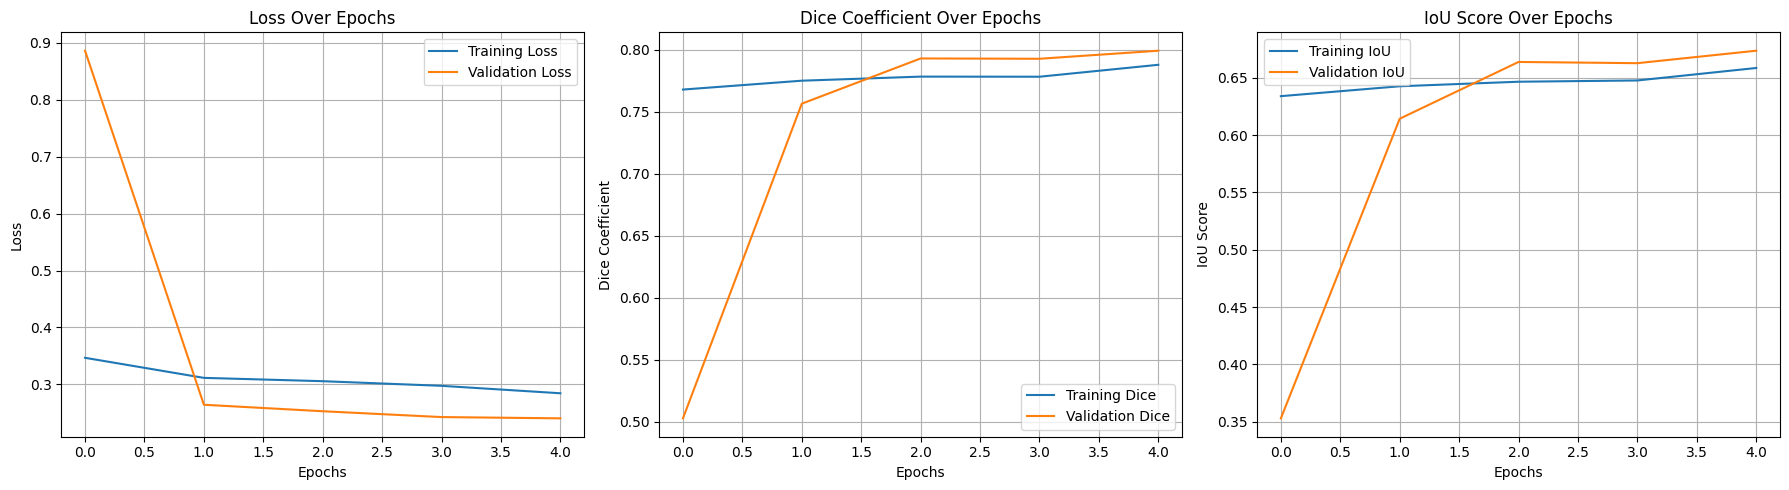

Best validation Dice: 0.7991 (Epoch 5)
Best validation IoU: 0.6736 (Epoch 5)


In [47]:
# Assuming we've already run the training and have the history
if 'history' in locals():
    plot_training_history(history)
else:
    print("Please run the training first to generate history")

# Task 5: Model Inference

After training our U-Net model, we need to be able to use it to make predictions on images. This process involves:

- Loading our trained model weights
- Processing input images through the model
- Visualizing the results alongside ground truth masks

The inference pipeline is important because it demonstrates how our model performs in practice and provides visual confirmation of what our metrics are measuring.

In [48]:
def load_trained_model(model_path, model_architecture, device):
    """
    Load a trained model from disk

    Args:
        model_path: Path to the saved model weights
        model_architecture: Instantiated model with correct architecture
        device: Device to load the model on

    Returns:
        Loaded model
    """
    # Load model weights
    model_architecture.load_state_dict(torch.load(model_path, map_location=device))
    model_architecture.to(device)
    model_architecture.eval()  # Set to evaluation mode

    print(f"Model loaded from {model_path}")
    return model_architecture


def run_inference(model, dataloader, device, num_samples=5):
    """
    Run inference on random samples from the dataloader

    Args:
        model: Trained model
        dataloader: DataLoader containing images and masks
        device: Device to run inference on
        num_samples: Number of random samples to process

    Returns:
        Tuple of (images, ground_truth_masks, predicted_masks)
    """
    # Get all data from the dataloader
    all_data = []
    for images, masks in dataloader:
        batch_samples = [(img, mask) for img, mask in zip(images, masks)]
        all_data.extend(batch_samples)

    # Randomly select samples
    import random
    selected_samples = random.sample(all_data, min(num_samples, len(all_data)))

    # Separate images and masks
    images = [item[0] for item in selected_samples]
    masks = [item[1] for item in selected_samples]

    # Stack the tensors
    images = torch.stack(images)
    masks = torch.stack(masks)

    # Run inference
    model.eval()
    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        predictions = torch.sigmoid(outputs) > 0.5  # Convert to binary mask
        predictions = predictions.cpu()

    return images, masks, predictions


def visualize_results(images, masks, predictions):
    """
    Visualize input images, ground truth masks, and predictions

    Args:
        images: Batch of input images (B, C, H, W)
        masks: Batch of ground truth masks (B, 1, H, W)
        predictions: Batch of predicted masks (B, 1, H, W)
    """
    # Number of samples
    num_samples = len(images)

    # Visualize results
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    # Handle the case of a single sample
    if num_samples == 1:
        axs = axs.reshape(1, -1)

    for i in range(num_samples):
        # Convert from tensor to numpy for plotting
        img = images[i].permute(1, 2, 0).numpy()  # Change from CHW to HWC

        # Normalize image for display if needed
        if img.max() > 1.0:
            img = img / 255.0

        mask = masks[i].squeeze().numpy()
        pred = predictions[i].squeeze().numpy()

        # Display image
        axs[i, 0].imshow(img)
        axs[i, 0].set_title("Input Image")
        axs[i, 0].axis('off')

        # Display ground truth
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title("Ground Truth")
        axs[i, 1].axis('off')

        # Display prediction
        axs[i, 2].imshow(pred, cmap='gray')
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate and print metrics for these samples
    dice_val = dice_coefficient(predictions.float(), masks)
    iou_val = iou_score(predictions.float(), masks)
    print(f"Dice coefficient for these samples: {dice_val:.4f}")
    print(f"IoU score for these samples: {iou_val:.4f}")

Model loaded from best_unet_model.pth


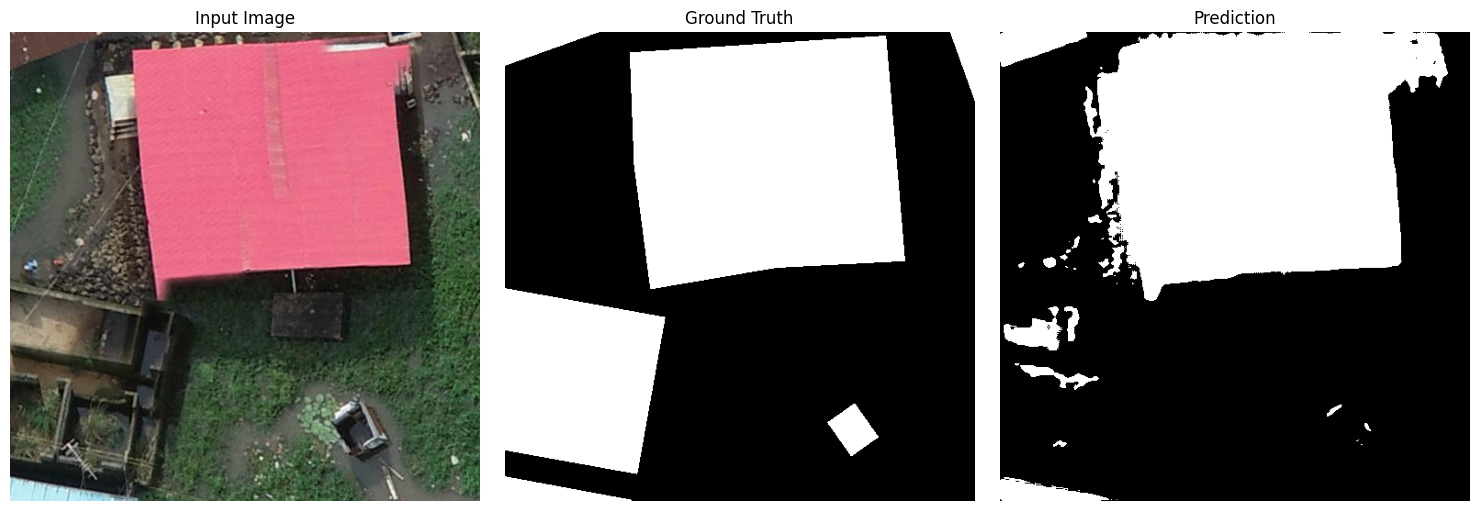

Dice coefficient for these samples: 0.7751
IoU score for these samples: 0.6327


In [49]:
# Path to saved model weights
model_path = 'best_unet_model.pth'

# Create a fresh model instance with the same architecture
inference_model = UNet(in_channels=3, out_channels=1)

# Load the trained weights
try:
    # 1. Load the model
    inference_model = load_trained_model(model_path, inference_model, device)

    # 2. Run inference to get predictions
    images, masks, predictions = run_inference(
        model=inference_model,
        dataloader=val_loader,
        device=device,
        num_samples=1
    )

    # 3. Visualize the results
    visualize_results(images, masks, predictions)

except FileNotFoundError:
    print(f"Model file not found at {model_path}. Please train the model first.")

Look at that!

Not bad for 5 epochs training, not bad at all!

In real case, deep learning usually trained in tens or even hundreds epoch.

# 🎉 Congratulations on Completing the Module! 🎉

Well done! You've successfully implemented a complete U-Net architecture for building segmentation from drone imagery. This module has taken you through the essential steps of deep learning model development for semantic segmentation.

Here's a summary of what we accomplished in this module:

1. **U-Net Architecture Implementation**
   - Built the fundamental building blocks (DoubleConv, DownSamplingBlock, UpSamplingBlock)
   - Assembled these components into a complete U-Net architecture
   - Verified the model structure through summary and forward pass tests
1. **Training Pipeline Setup**
   - Selected appropriate loss functions for segmentation (BCEWithLogitsLoss)
   - Configured optimizer (Adam) and learning parameters
   - Implemented metrics tracking (IoU, Dice coefficient)
1. **Training Loop Implementation**
   - Created training and validation functions
   - Set up visualization for training progress
   - Added model checkpointing to save the best model
1. **Inference Pipeline**
   - Developed functions to load trained models
   - Created an inference process for making predictions
   - Implemented visualization tools to compare predictions with ground truth

# 🚀 Module Task: Extend Your U-Net for Advanced Building Segmentation

We will play a bit with our implementation of unet, do the following:

1. **USE a Different Loss Function**
    - Replace BCEWithLogitsLoss with Dice Loss or a combined BCE-Dice Loss
    - Compare training results with your original implementation
    - Visualize how the different loss affects segmentation quality
1. **IMPLEMENT your own version of an optimizer**
    - If you feel less comfortable, implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer (`torch.optim.SGD`)
    - If you feel more comfortable, implement [Adam Optimizer](https://optimization.cbe.cornell.edu/index.php?title=Adam) without using a built-in optimizer (`torch.optim.Adam`)
    - Then use your version of optimizer to replace the optimizer used previously.
    - Check how it compares with the built-in optimizer (train the model, then visualize the progression!)

**OPTIONAL**

Make a prediction for the whole image and combine them as one complete image, here's hints:

1. Prediction Patch
    - In the previous module, you've patchify one raster into multiple patches
    - You may want to do the same, but with the size of patch equal to the stride distance (e.g. patch size = 512, then stride_dist=512)
    - This is to make sure there's no overlap on the prediction patches since it is unnecessary in this case (prediction)
1. Predicting
    - Prepare the model and run it against the prepared patch
    - Save the predicted patches into a folder
1. Merging
    - Merge the predicted patches into one raster (image)

**You've built a solid foundation!** These extensions will help you develop expertise in semantic segmentation that transfers to many computer vision applications, from urban planning to disaster response.

**Looking forward to seeing your enhanced models in action!**

# Further Reading

- https://poloclub.github.io/cnn-explainer/
- https://www.learnpytorch.io/08_pytorch_paper_replicating/#81-getting-a-visual-summary-of-our-vit-model